In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
import h5py
import numpy as np
import seaborn as sn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib as mpl
import sys
from pathlib import Path

# import custom functions from src folder
module_path = str(Path.cwd() / "../src")

if module_path not in sys.path:
    sys.path.append(module_path)

from util import *

In [19]:
sn.set_palette("tab10")
sn.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

$
\begin{aligned}
& \frac{1}{T}\sum_{t, l} w_{t,l} A(c|\alpha_{t,l}) B_1(x_1|\beta_{t,l}) B_2(x_2|\gamma_{t,l}) \\
\end{aligned}
$

In [20]:
def process_data(file, y_labels, x_labels, test=False):
    # Read data
    data = h5py.File(file, "r")
    df = pd.DataFrame(columns = x_labels)

    for i in range(len(x_labels)):
        df[x_labels[i]] = np.array(data["data"][:, i]).flatten()
   
    if ("x1" in x_labels):
        df = cartesian_to_polar_df(df, "x1", "x2", "r_x", "a_x")

    elif ("r_x" in x_labels):
        df = polar_to_cartesian_df(df, "x1", "x2", "r_x", "a_x")

    #df["Confidence"] = data["confidence"]
    for i in range(len(y_labels)):
        df[f"Std_samples_{y_labels[i]}"] = np.std(np.array(data["samples"][:, :, i]), axis=-1)
    
    # Get truth label values (annoying because text is not read as text, should fix)
    # Is fixed, just update
    if (test == False):
        df["Truth_value"] = data["truth"]
        df["Truth"] = y_labels[0]
        blue = 1.0
        df_copy = df.copy()
        mask = df_copy["Truth_value"] == blue
        df.loc[mask, "Truth"] = y_labels[1]
    
    # Get estimated probabilities
    for i in range(len(y_labels)):
        df[y_labels[i]] = data["probabilities"][:,i]
        df[f"P({y_labels[i]}|x)"] = data["probabilities"][:,i]

    # Get 25-75% error bars
    for i in range(len(y_labels)):
        df[f"quantile25_{y_labels[i]}"] = data["quantiles"][:, 1, i]
        df[f"quantile75_{y_labels[i]}"] = data["quantiles"][:, 2, i]
        df[f"Error_{y_labels[i]}"] = (df[f"quantile75_{y_labels[i]}"] - df[f"quantile25_{y_labels[i]}"])/2

    # Could be some NaNs
    len_nan = len(df[df.isnull().any(axis=1)])
    if len_nan > 0:
        print(f"Dropping {len_nan} rows of NaNs")
        df = df.dropna()

    # Get inferred color
    df["Inferred_color"] = df[[y_labels[0], y_labels[1]]].idxmax(axis=1)
    
    return df

In [21]:
# Custom plot function
def plot_distributions(df):

    fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (15, 8), layout="constrained")

    # Plot 2D data points
    df_red = df[df["color"] == "red"]
    sn.scatterplot(df_red, x="x1", y = "x2", c="red", alpha=0.1, ax=axs[0][0])
    df_blue = df[df["color"] == "blue"]
    sn.scatterplot(df_blue, x="x1", y = "x2", c="blue", alpha=0.1, ax=axs[1][0])
    axs[0][0].set_xlim(min(df["x1"]), max(df["x1"]))
    axs[0][0].set_ylim(min(df["x2"]), max(df["x2"]))
    axs[1][0].set_xlim(min(df["x1"]), max(df["x1"]))
    axs[1][0].set_ylim(min(df["x2"]), max(df["x2"]))
    
    # Plot angular distribution
    sn.histplot(df_red, x="a_x", color="red", ax=axs[0][1])
    sn.histplot(df_blue, x="a_x", color="blue", ax=axs[1][1])
    axs[0][2].set_xlabel(r"$\theta_x$")
    axs[1][2].set_xlabel(r"$\theta_x$")

    # Plot radial distribution
    sn.histplot(df_red, x="r_x", color="red", ax=axs[0][2])
    sn.histplot(df_blue, x="r_x", color="blue", ax=axs[1][2])
    axs[0][2].set_xlabel(r"$|\vec{x}|$")
    axs[1][2].set_xlabel(r"$|\vec{x}|$")
    axs[0][2].set_xlim(0, 25)
    axs[1][2].set_xlim(0, 25)

    # Ticks
    for ax in axs.flatten():
        ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
        ax.tick_params(which="major", length=6)
        ax.minorticks_on()

    return fig, ax

In [22]:
def plot_results(df, weight_key, ax, suptitle, grid=False):
    ax.set_title(suptitle)
    #sn.set_theme(style="whitegrid")

    cmap = red_blue_cmap()
    if grid:
        ax.hist2d(x= df["x1"], y=df["x2"], weights=df[weight_key], 
                bins = 100,
                norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False),
                cmap=cmap)
    else:
        sn.scatterplot(data = df, x="x1", y="x2", ax = ax, hue=weight_key, 
                    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False),
                    size="Std_samples_blue", size_norm = (0.1, 0.2), sizes=(10, 200),
                        palette=cmap, legend=False)
    
    ax.set_xlim(-25, 25)
    ax.set_ylim(-25, 25)
    ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
    ax.tick_params(which="major", length=6)
    ax.minorticks_on()
    ax.set_aspect('equal', adjustable='box')

    return ax

In [23]:
def plot_uncertainties(df, ax, suptitle, grid=False):
    ax.set_title(suptitle)
    sn.set_theme(style="whitegrid")
    #cmap = sn.cubehelix_palette(rot=-.2, as_cmap=True)

    if grid:
        ax.hist2d(x= df["x1"], y=df["x2"], weights=df["Error_blue"], 
                bins = 100,
                norm = mpl.colors.Normalize(vmin=0.1, vmax=0.3, clip=False),
                cmap = "viridis")
    else:
        sn.scatterplot(data = df, x="x1", y="x2", ax = ax, hue="Error_blue", 
                    #hue_norm = mpl.colors.Normalize(vmin=0.1, vmax=0.3, clip=False),
                    #size="Error_blue", size_norm = (0.1, 0.3), sizes=(10, 200),
                    legend=False)
    
    #ax.set_xlim(-25, 25)
    #ax.set_ylim(-25, 25)

    return ax

### Setup and constants

In [24]:
# Setup

#MCMC constants
n_samples = 1200
n_data = [250, 1000, 5000]
#n_data = [250, 2100, 3600, 5000]
n_chains = 10
n_plots = len(n_data)

#Data constants
R2 = 3
k_red = 7
k_blue = 3
R1_min = 6
scale = 1
vary_a1 = False
vary_R2 = False
p_red = 0.5
polar = False
tag = f'r2_{R2}_kr{k_red}_kb{k_blue}_r1min{R1_min}_s{scale}_vary_r2_{vary_R2}_vary_a1_{vary_a1}_pRed_{p_red}'

# Data labels
y_labels = ["red", "blue"]
if polar:
    x_labels = ["r_x", "a_x"]
else:
    x_labels = ["x1", "x2"]

# Read files
folderpath = "inference"
train_n = 50000
trainfile = f"train_n_{train_n}_{tag}"
truthfile = f"analytical_solution_x1_x2_grid_{tag}_nxMC_200_nr1MC_200"
#testfile = f"test_n_10000_{tag}"
testfile = f"val_n_5000_{tag}"
gridfile = "x1_x2_grid"

if polar:
    analysis_folders = [f"{trainfile}/nsamples-1200_nchains-{n_chains}_ndata-{n_data[i]}_POLAR" for i in range(n_plots)]
else:
    analysis_folders = [f"{trainfile}/nsamples-1200_nchains-{n_chains}_ndata-{n_data[i]}" for i in range(n_plots)]
#valfiles = [f"{folderpath}/{folder}/{valfile}_inferred.h5" for folder in analysis_folders]
testfiles = [f"{folderpath}/{folder}/{testfile}_inferred.h5" for folder in analysis_folders]
gridfiles = [f"{folderpath}/{folder}/{gridfile}_inferred.h5" for folder in analysis_folders]
train_data = pd.read_csv(f"../data/{trainfile}.csv")
truth_data = pd.read_csv(f"../analytical/results/{truthfile}.csv")

grid_dfs = [process_data(file, y_labels, x_labels, test=True) for file in gridfiles]
test_dfs = [process_data(file, y_labels, x_labels, test=False) for file in testfiles]

#Correct analytical solution if class distribution is not equal
if p_red != 0.5:
    truth_data["P_red_and_x"] = truth_data["P_red_and_x"]*(p_red)/0.5
    truth_data["P_blue_and_x"] = truth_data["P_blue_and_x"]*(1-p_red)/0.5
    truth_data["P_x"] = truth_data["P_red_and_x"] + truth_data["P_blue_and_x"]
    truth_data["P_red_given_x"] = truth_data["P_red_and_x"]/truth_data["P_x"]
    truth_data["P_blue_given_x"] = truth_data["P_blue_and_x"]/truth_data["P_x"]


# Key to use for plotting
weight_key = f"P({y_labels[1]}|x)"

In [25]:
test_dfs[0]

,x1,x2,r_x,a_x,Std_samples_red,Std_samples_blue,Truth_value,Truth,red,P(red|x),blue,P(blue|x),quantile25_red,quantile75_red,Error_red,quantile25_blue,quantile75_blue,Error_blue,Inferred_color
0,-10.685982,0.247318,10.688843,3.118453,0.103355,0.103355,0.0,red,0.602670,0.602670,0.397330,0.397330,0.529401,0.677938,0.074269,0.322062,0.470599,0.074269,red
1,6.517934,18.842814,19.938283,1.237769,0.176782,0.176782,0.0,red,0.709553,0.709553,0.290447,0.290447,0.606410,0.838193,0.115892,0.161807,0.393590,0.115892,red
2,10.101325,7.399758,12.521709,0.632241,0.128971,0.128971,1.0,blue,0.455501,0.455501,0.544499,0.544499,0.368211,0.534399,0.083094,0.465601,0.631789,0.083094,blue
3,6.168565,3.672720,7.179141,0.537025,0.103559,0.103559,1.0,blue,0.362572,0.362572,0.637428,0.637428,0.284634,0.429465,0.072416,0.570535,0.715366,0.072416,blue
4,-6.823455,-6.068953,9.131907,3.868535,0.125316,0.125316,1.0,blue,0.442660,0.442660,0.557340,0.557340,0.353921,0.532262,0.089170,0.467738,0.646079,0.089170,blue
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,10.516936,4.502822,11.440339,0.404535,0.122078,0.122078,1.0,blue,0.404679,0.404679,0.595321,0.595321,0.314957,0.494165,0.089604,0.505835,0.685043,0.089604,blue
4996,11.995977,-10.837092,16.166200,5.548498,0.162608,0.162608,0.0,red,0.675025,0.675025,0.324975,0.324975,0.579426,0.785541,0.103057,0.214459,0.420574,0.103057,red
4997,-2.321882,-5.453356,5.927076,4.309865,0.100340,0.100340,1.0,blue,0.203635,0.203635,0.796365,0.796365,0.128279,0.260706,0.066213,0.739294,0.871721,0.066213,blue
4998,13.664635,7.015536,15.360338,0.474317,0.119620,0.119620,0.0,red,0.645820,0.645820,0.354180,0.354180,0.552200,0.754202,0.101001,0.245798,0.447800,0.101001,red


### Plot training data and distributions

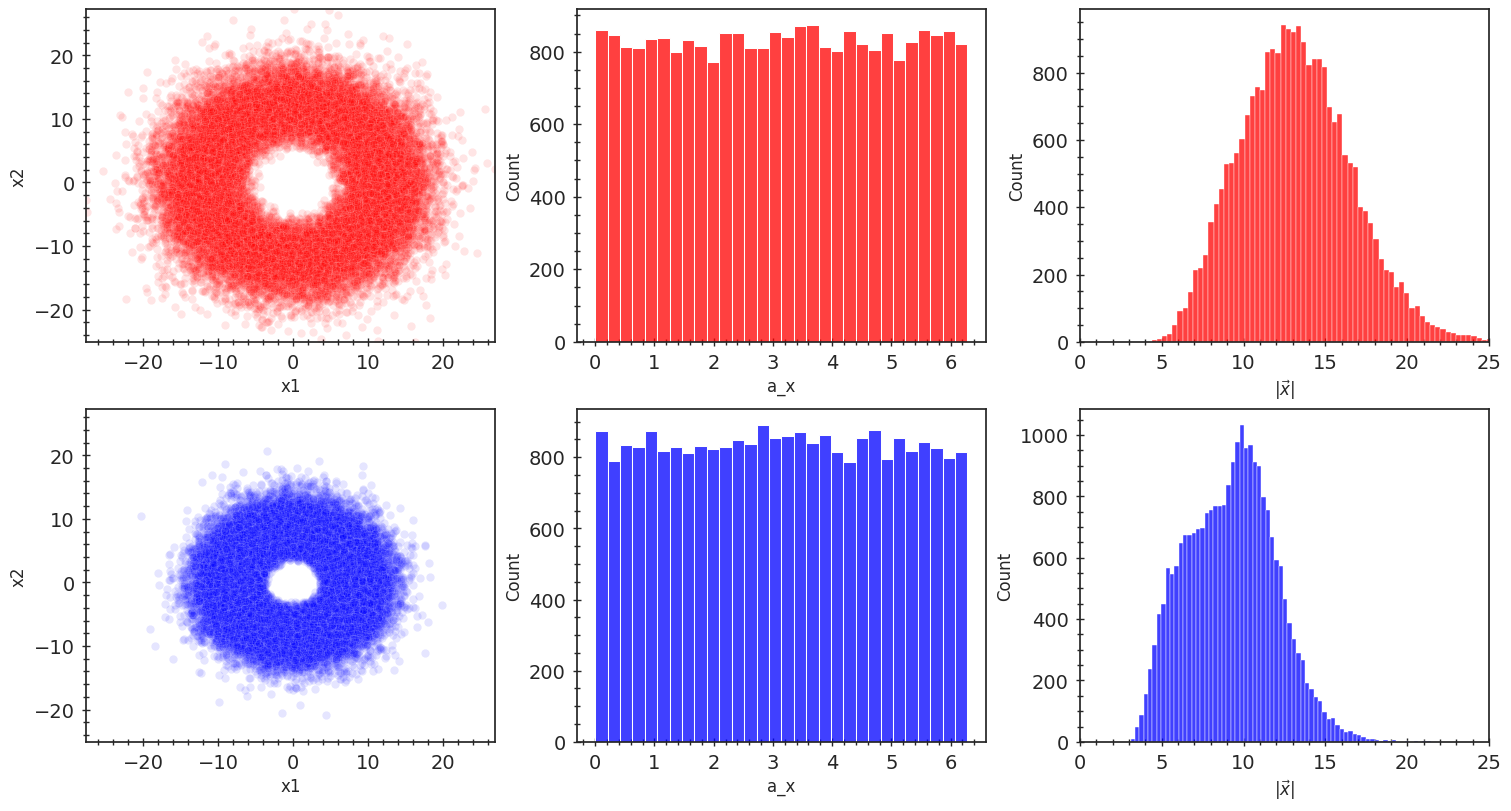

In [26]:
fig, ax = plot_distributions(train_data)

### Results from inference

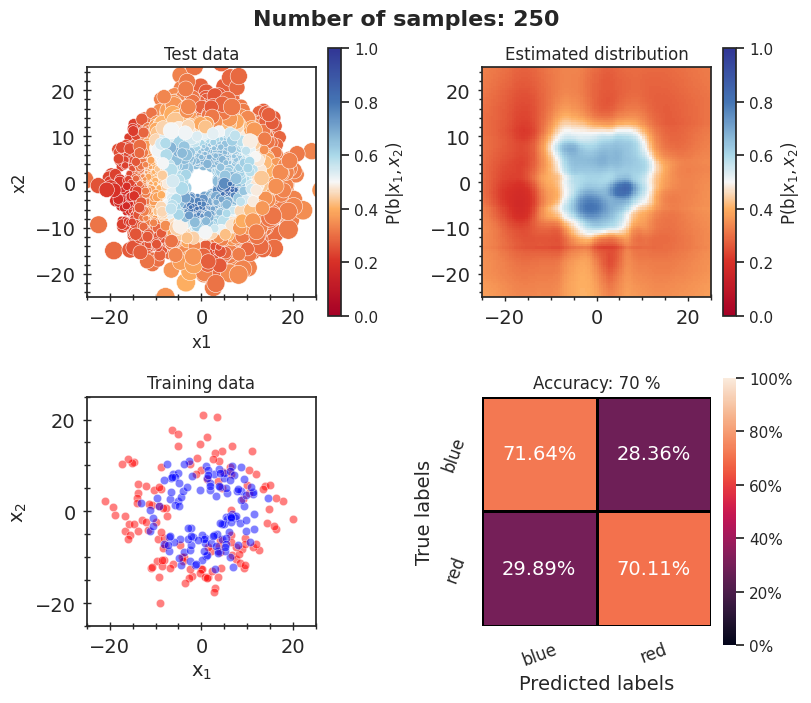

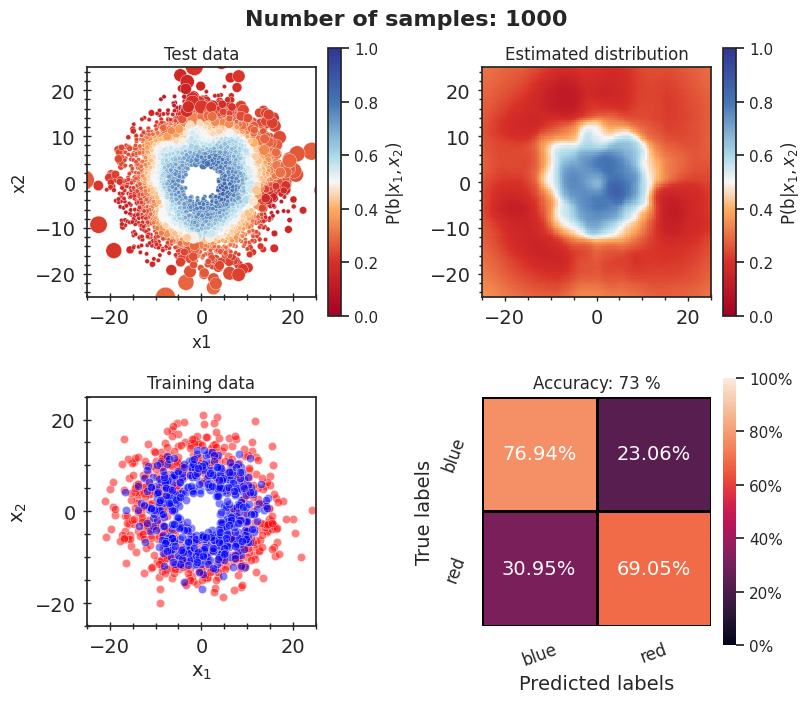

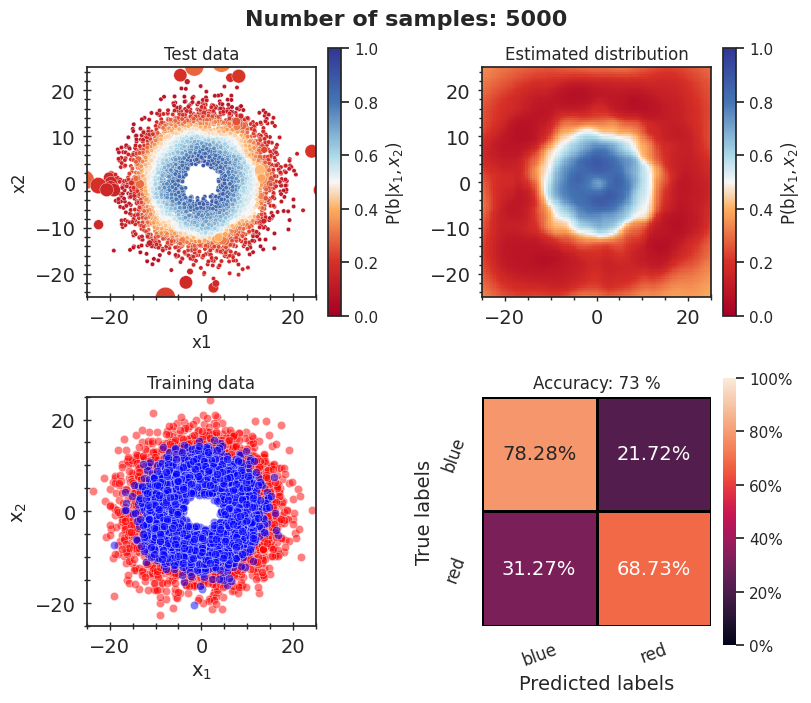

In [27]:

# Plot results

for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8,7), layout="constrained")
    
    #plot data
    axs[0][0] = plot_results(test_dfs[i], weight_key, axs[0][0], "Test data")
    axs[0][1] = plot_results(grid_dfs[i], weight_key, axs[0][1], "Estimated distribution", grid=True)
    axs[1][0] = plot_data(train_data[0:n_data[i]], axs[1][0], "Training data")
    axs[1][1] = plot_conf_matrix(test_dfs[i], "Truth", "Inferred_color", ["blue", "red"], axs[1][1])
    
    cmap = red_blue_cmap()
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'P(b|$x_1, x_2$)', ax=axs[0][0])
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'P(b|$x_1, x_2$)', ax=axs[0][1])

    fig.suptitle(f"Number of samples: {n_data[i]}", size=16, fontweight="bold")
    #plt.savefig(f"../../fig/results/inferno/{testfile}_{trainfile}_n_{n_data[i]}")

#plt.show()
    

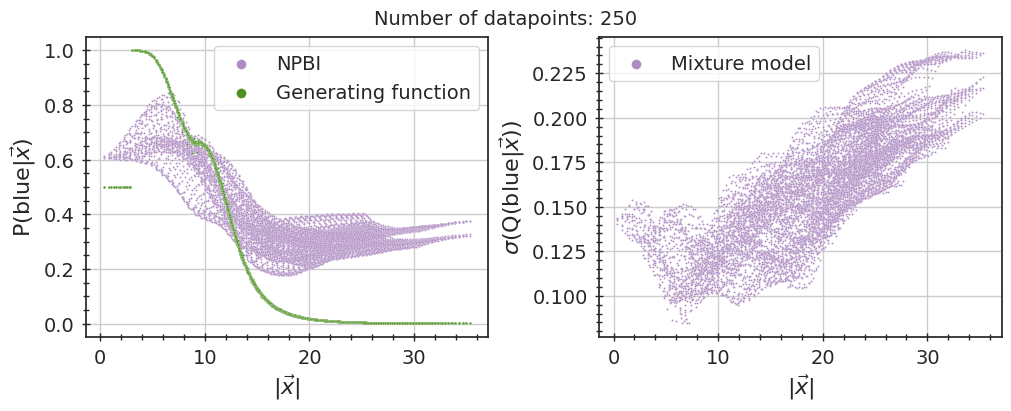

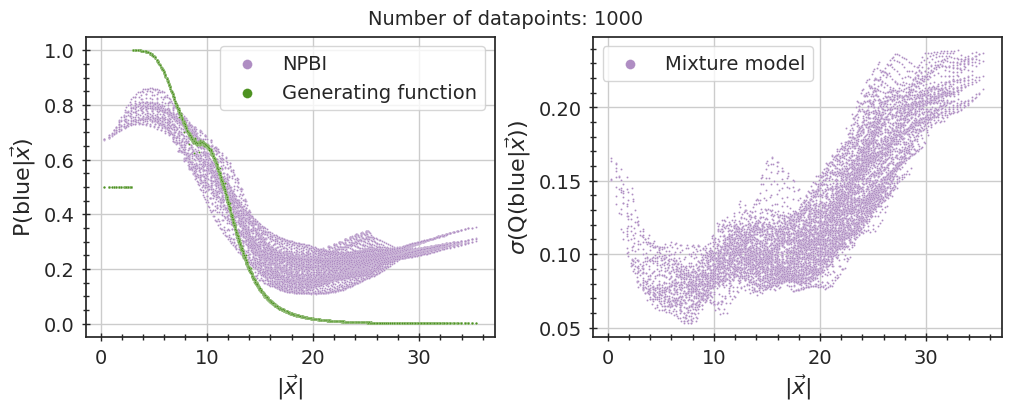

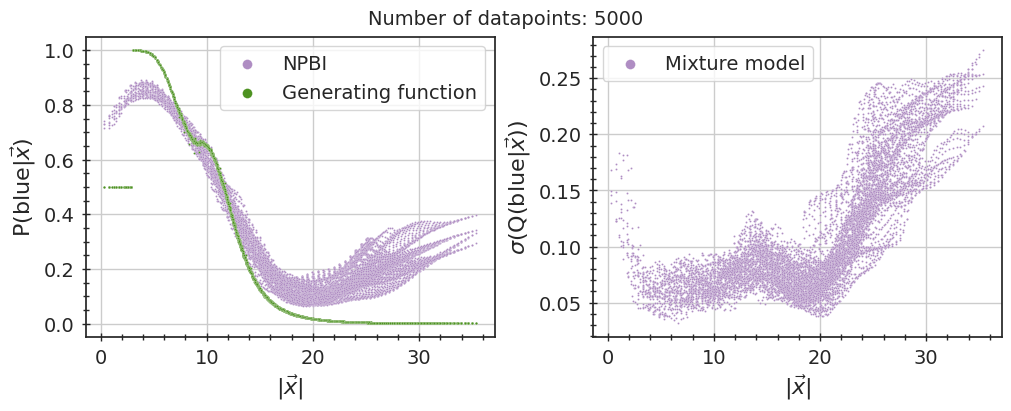

In [28]:
for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (10, 4), layout="constrained")
    sn.scatterplot(grid_dfs[i], x="r_x", y="P(blue|x)", s=2, ax = axs[0], label="NPBI", color="#af8dc3")
    sn.scatterplot(truth_data, x="r_x", y="P_blue_given_x", s=2, ax = axs[0], label="Generating function", color="#4d9221")
    axs[0].set_ylabel(r"P(blue|$\vec{x}$)", fontsize=16)

    sn.scatterplot(grid_dfs[i], x="r_x", y="Std_samples_blue", s=2, ax = axs[1], label="Mixture model", color="#af8dc3")
    axs[1].set_ylabel(r"$\sigma$(Q(blue|$\vec{x}$))", fontsize=16)

    for ax in axs:
        ax.legend(markerscale=5, fontsize=14)
        ax.set_xlabel(r"$|\vec{x}|$", fontsize=16)
        ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
        ax.tick_params(which="major", length=6)
        ax.minorticks_on()
        ax.grid()
    fig.suptitle(f"Number of datapoints: {n_data[i]}", fontsize=14)


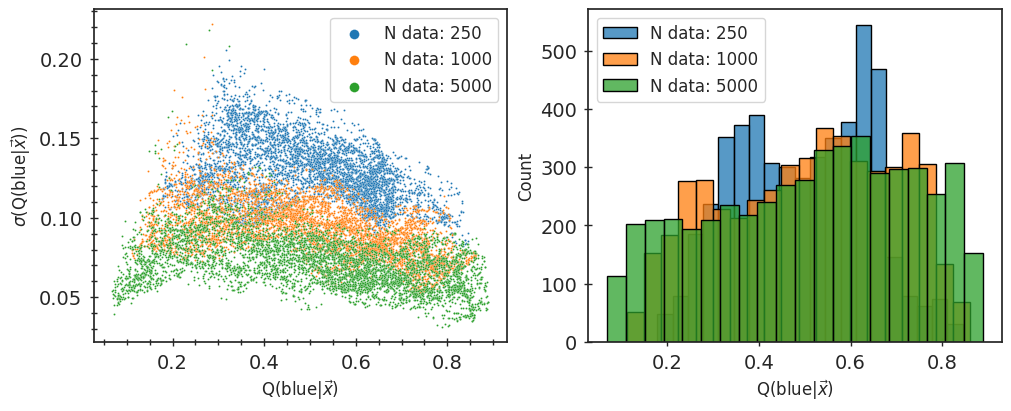

In [34]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (10, 4), layout="constrained")
for i in range(len(n_data)):
    sn.scatterplot(test_dfs[i], x="P(blue|x)", y="Std_samples_blue", s=2, label=f"N data: {n_data[i]}", ax = axs[0])
    axs[0].legend(markerscale=5, fontsize=12)
    axs[0].set_ylabel(r"$\sigma$(Q(blue|$\vec{x}$))", fontsize=12)
    axs[0].set_xlabel(r"Q(blue|$\vec{x}$)", fontsize=12)
    sn.histplot(test_dfs[i], x="P(blue|x)", label=f"N data: {n_data[i]}", ax = axs[1], edgecolor="black", linewidth=1, bins=20)
    axs[1].legend(markerscale=5, fontsize=12)
    axs[1].set_ylabel("Count", fontsize=12)
    axs[1].set_xlabel(r"Q(blue|$\vec{x}$)", fontsize=12)

    for ax in axs:
        ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
        ax.tick_params(which="major", length=6)
    axs[0].minorticks_on()
    #fig.suptitle(f"Number of training datapoints: {n_data[i]}", size=16, fontweight="bold")

### Calibration

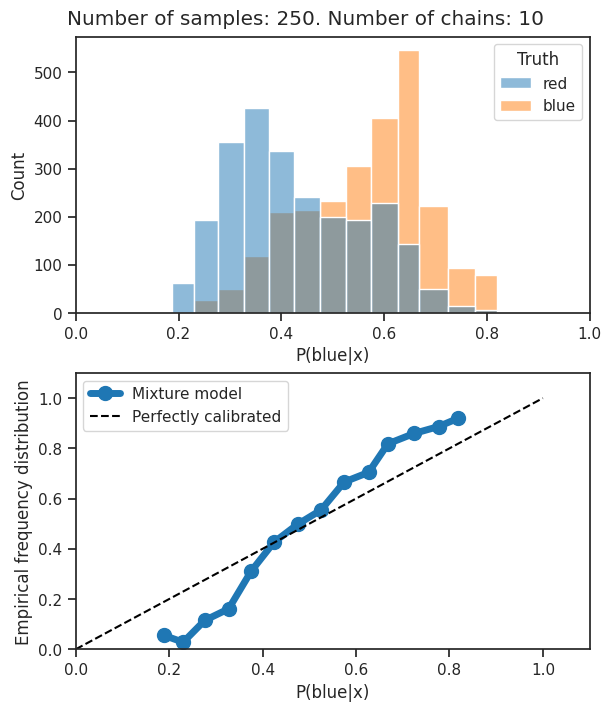

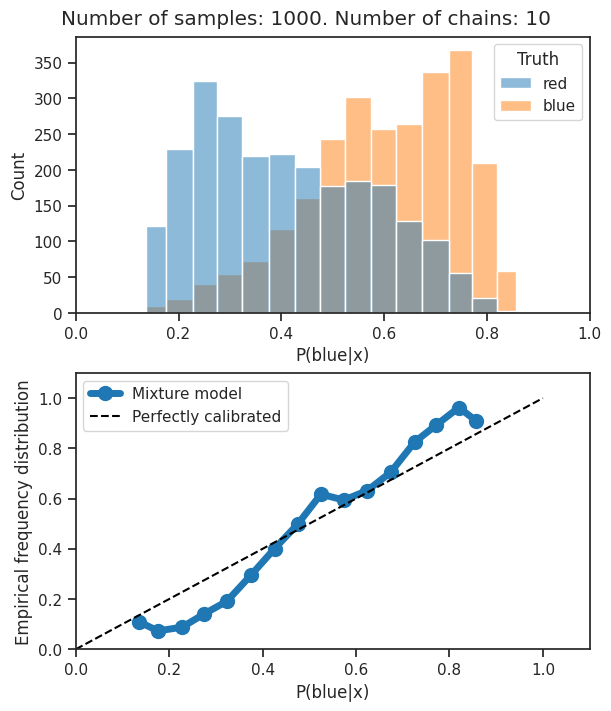

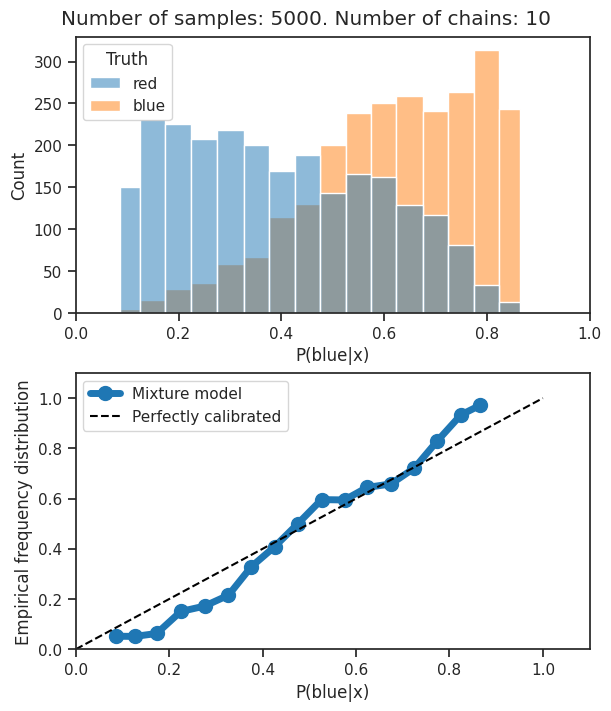

In [30]:
from sklearn.calibration import CalibrationDisplay
from sklearn.calibration import calibration_curve

for i in range(n_plots):
    #Get confidence for red
    prob_cal, prob_pred = calibration_curve(test_dfs[i]["Truth_value"], test_dfs[i]["P(blue|x)"], n_bins=20, strategy="uniform")
    pred_bins=list(prob_pred)

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(6, 7), layout="constrained")
    sn.histplot(test_dfs[i], x="P(blue|x)", hue="Truth", ax=ax[0], stat="count", bins=pred_bins)
    ax[0].set_xlim(0,1)
    ax[1].plot(prob_pred, prob_cal, linewidth=5, markersize=10, marker="o", label ="Mixture model")
    ax[1].set_xlim(0,1.1)
    ax[1].set_ylim(0,1.1)
    x = np.linspace(0, 1, 10)
    ax[1].plot(x, x, color="black", linestyle="--", label="Perfectly calibrated")
    ax[1].set_xlabel("P(blue|x)")
    ax[1].set_ylabel("Empirical frequency distribution")
    ax[1].legend()
    fig.suptitle(f"Number of samples: {n_data[i]}. Number of chains: {n_chains}")